In [27]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.models import Model, load_model
import keras.backend as K

import model as tcav_model
import tcav as tcav
import utils as utils
import activation_generator as act_gen
import tensorflow as tf
import utils_plot as utils_plot
import cav as cav

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from numpy.linalg import norm

import pickle

from os import listdir
from os.path import isfile, join
import operator
from PIL import Image
from keras.preprocessing import image

import os
import math

import PIL.Image
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import preprocess_input

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
model = load_model('v3_model.h5')

Instructions for updating:
Colocations handled automatically by placer.


/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
sess = K.get_session()

endpoints_v3 = dict(
    input=model.inputs[0].name,
    input_tensor=model.inputs[0],
    logit=model.outputs[0].name,
    prediction=model.outputs[0].name,
    prediction_tensor=model.outputs[0],)

tf.logging.set_verbosity(0)

working_dir = '/home/tyler/Desktop/tcav_on_azure'

label_path = os.path.join(working_dir,'labels.txt')

mymodel = tcav_model.KerasModelWrapper(sess, 
        label_path, [299, 299, 3], endpoints_v3, 
        'InceptionV3_public', (-1, 1))

Instructions for updating:
Use tf.cast instead.


In [18]:
## CAV loop
source_dir = working_dir + '/concepts/'
activation_dir =  working_dir + '/activations/'

target_class = 'zebra'
concepts = ['striped_sub_1', 'random500_3']

hparams = tf.contrib.training.HParams(model_type='linear', alpha=.1)
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=50)

bn_names = ['mixed0','mixed1','mixed2','mixed3','mixed4','mixed5','mixed6','mixed7','mixed8','mixed9','mixed10']
bn_names = ['mixed9']

for bottleneck in  bn_names:
    acts = act_generator.process_and_load_activations([bottleneck], concepts + [target_class])
    cav.get_or_train_cav(concepts,bottleneck,acts,cav_hparams=hparams,cav_dir='cavs')


['striped_sub_1', 'random500_3', 'zebra']


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [ ]:
#cav = None

In [19]:
class_1 = 'striped_sub_1'
class_2 = 'random500_3'

layer = 'mixed9'
lm_type = 'linear'
#lm_type = 'logistic'
cav_name = class_1 + '-' + class_2 + '-' + layer + '-' + lm_type + '-0.1'
sub_path = 'cavs/' + cav_name 

# Load training/testing data
path = os.path.join(working_dir,sub_path + '_test.pkl')
with open(path, 'rb') as f:
    data = pickle.load(f)
    
d = dict(data)
x_train = d['x_train']
x_test = d['x_test']
y_train = d['y_train']
y_test = d['y_test']
y_pred = d['y_pred']

path = os.path.join(working_dir,sub_path + '.pkl')

with open(path, 'rb') as f:
    cav_data = pickle.load(f)
this_cav = cav_data['cavs'][0]

In [55]:
pca_components = pickle.load(open('pca/pca_components_mixed9.pkl', 'rb'))

In [56]:
# TRAIN
x_train_embed_pca = np.dot(pca_components, x_train.T)
color_train_pca = ['red' if y == 0 else 'blue' for y in y_train]

# TEST
x_test_embed_pca = np.dot(pca_components, x_test.T)

light_blue, light_red = '#b3b8fb', '#f6889f'

color_test_pca = [light_red if y == 0 else light_blue for y in y_test]


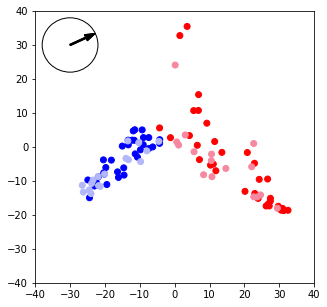

In [57]:
fig = plt.figure(figsize=[5,5])

plt.scatter(x_train_embed_pca[0], x_train_embed_pca[1], color = color_train_pca)
plt.scatter(x_test_embed_pca[0], x_test_embed_pca[1], color = color_test_pca) #, alpha = .6)

circ = plt.Circle((-30, 30), radius=8, edgecolor='black', facecolor='None')
ax = plt.gca()

ax.add_patch(circ)

cav_pca = np.dot(pca_components, this_cav.T)
cav_norm = vector_norm(cav_pca)
cav_norm *= 8
#origin = [-30],[30]
#plt.quiver(*origin, cav_norm[0], cav_norm[1], color='black',scale=100)

arrow_start = [-30,30]

my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None)
ax.add_patch(my_arrow)


plt.xlim([-40,40])
plt.ylim([-40,40])

fig_path = 'figs/jul_9/pca_' + cav_name + '.png'

path = os.path.join(working_dir,fig_path)
#plt.savefig(path,dpi=200)


In [25]:
#x_train

In [40]:
lm = linear_model.SGDClassifier(alpha=.1)

In [41]:
lm.fit(x_train,y_train)

/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
lm_2 = linear_model.SGDClassifier(alpha=.1)

In [43]:
lm_2.fit(x_train,y_train)

/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [46]:
#lm_2.coef_[0][:10]

In [105]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [106]:
this_cav = -lm.coef_[0]

In [153]:
## get original CAV
lm.fit(x_train,y_train)
original_CAV = -lm.coef_[0]

cavs = []

## remove one point
for idx, x_point in enumerate(x_train):
    if y_train[idx]==0:
        x_train_new = np.delete(x_train, idx, axis=0)
        y_train_new = np.delete(y_train, idx, axis=0)
        
        new_lm = linear_model.SGDClassifier(alpha=.1)
        new_lm.fit(x_train_new,y_train_new)
        cav_params = -new_lm.coef_[0]
        sim = euclidean_distance(vec_norm(cav_params),vec_norm(original_CAV))
        cavs.append([idx,cav_params,sim])
        
        

In [209]:
cavs_sims = np.array([a[2] for a in cavs])

(0.9172643831768572, 22)

In [159]:
#x_train.shape

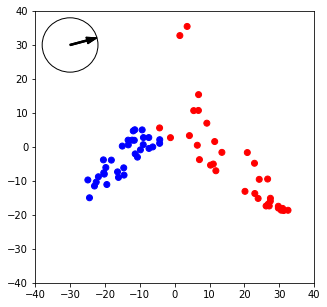

In [163]:
## Plot orig
this_cav = original_CAV
x_train_embed_pca = np.dot(pca_components, x_train.T)
color_train_pca = ['red' if y == 0 else 'blue' for y in y_train]

fig = plt.figure(figsize=[5,5])
plt.scatter(x_train_embed_pca[0], x_train_embed_pca[1], color = color_train_pca)

circ = plt.Circle((-30, 30), radius=8, edgecolor='black', facecolor='None')
ax = plt.gca()
ax.add_patch(circ)

cav_pca = np.dot(pca_components, this_cav.T)
cav_norm = vector_norm(cav_pca) * 8

arrow_start = [-30,30]

my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None)
ax.add_patch(my_arrow)

xlim = plt.xlim([-40,40])
ylim = plt.ylim([-40,40])

In [164]:
#cavs[22][1]

In [192]:
x_train_embed_pca.shape

(2, 67)

In [197]:
x_train_embed_pca[:,6]

array([-7.428035 ,  2.7521267], dtype=float32)

In [264]:
#this_idx = cavs[15][0]

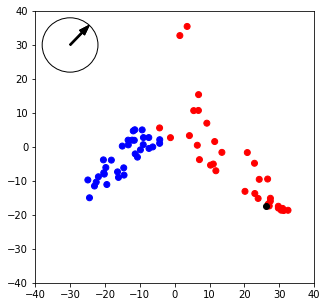

In [267]:
## Plot new
idx = 1
this_cav = cavs[idx][1]
x_train_new = np.delete(x_train, idx, axis=0)
x_rem = x_train[idx]
y_train_new = np.delete(y_train, idx, axis=0)

x_train_embed_pca = np.dot(pca_components, x_train_new.T)
color_train_pca = ['red' if y == 0 else 'blue' for y in y_train_new]

b = np.dot(pca_components, x_rem.T)
a = np.delete(x_train_embed_pca, idx, axis=1)

fig = plt.figure(figsize=[5,5])
plt.scatter(x_train_embed_pca[0], x_train_embed_pca[1], color = color_train_pca)

plt.scatter(b[0], b[1], color = 'black')


circ = plt.Circle((-30, 30), radius=8, edgecolor='black', facecolor='None')
ax = plt.gca()
ax.add_patch(circ)

cav_pca = np.dot(pca_components, this_cav.T)
cav_norm = vector_norm(cav_pca) * 8
arrow_start = [-30,30]

my_arrow = plt.arrow(arrow_start[0], arrow_start[1], cav_norm[0], cav_norm[1],width=.4,
                     length_includes_head=True,head_width=2,fc='k', ec=None)
ax.add_patch(my_arrow)

xlim = plt.xlim([-40,40])
ylim = plt.ylim([-40,40])

In [268]:
cavs[15][0]

37

In [256]:
x_train_embed_pca.shape

(2, 66)

In [217]:
np.min(cavs_sims),np.min(cavs_sims)

(0.9172643831768572, 0.9172643831768572)

In [245]:
cavs_sims[8]

1.1136383804387373

In [12]:
## define functions
def vector_norm(vec):
    norm_const = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
    return vec / norm_const

def vec_norm(vec):
    return  vec / np.linalg.norm(vec)

## CAV distance
def euclidean_distance(a,b):
    return np.linalg.norm(a-b)